### Use K-means algorithm for clustering pixel features and generate paint filter

In [1]:
%matplotlib notebook

import numpy as np
import math
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
from skimage.color import rgb2grey

In [2]:
class MyKmeansApp:
    
    def __init__(self, img, num_clusters=2):
        self.k = num_clusters
        # iteration counter
        self.iteration = 0   
        # energy - "sum of squared errors" (SSE)
        self.energy = np.infty 
        num_rows = self.num_rows = img.shape[0]
        num_cols = self.num_cols = img.shape[1]
        self.im = img.copy()
        # creates a zero-valued (double) matrix of size Kx3
        self.means = np.zeros((self.k,3),'d') 
        self.init_means()
        # special label value indicating pixels not in any cluster (e.g. not yet) 
        self.no_label = num_clusters  
        # mask "labels" where pixels of each "region" will have a unique index-label (like 0,1,2,3,..,K-1)
        # the default mask value is "no-label" (K) implying pixels that do not belong to any region (yet)
        self.labels = np.full((num_rows, num_cols), fill_value=self.no_label, dtype=np.int)
        
        
    def return_img(self):
        error = self.compute_k_means_clusters()
        # loop until error is acceptable
        while error >= 0.1:
            error = self.compute_k_means_clusters()
        # by now we finished the clustering and need to assign the color to each cluster
        self.change_color()
        return self.im
       
        
    def change_color(self):
        im = self.im 
        k = self.k
        labels = self.labels
        for i in range(k):
            # find all pixels
            posx, posy = np.where(labels == i)
            num = len(posx)
            # find the mean color
            color = self.means[i,:3] 
            # change color while adjusting brightness
            for j in range(num):
                im[posx[j]][posy[j]][0] = min(color[0] + 10,255)
                im[posx[j]][posy[j]][1] = min(color[1] + 10,255)
                im[posx[j]][posy[j]][2] = min(color[2] + 10,255)
        
            
    
    def init_means(self): 
        # resets iteration counter and the energy
        self.iteration = 0    
        self.energy = np.infty  

        poolX = range(self.num_cols)
        poolY = range(self.num_rows)
        
        # generate K random pixels (Kx2 array with X,Y coordinates in each row)
        random_pixels = np.array([np.random.choice(poolX,self.k),np.random.choice(poolY,self.k)]).T
        
        for label in range(self.k):
            self.means[label,:3] = self.im[random_pixels[label,1],random_pixels[label,0],:3]
    
    # This function compute average values for R, G, B channel (feature component) at pixels in each cluster
    # represented by labels in given mask "self.labels" storing indeces in range [0,K). The averages should be
    # saved in (Kx5) matrix "self.means". The return value should be the number of non-empty clusters. 
    def compute_means(self):
        non_empty_clusters = 0
        # in this step, we assume the clusters are fixed
        # we loop through the lable to compute its mean
        for i in range(self.k):
            # we first find the position(posx,posy) of the label with the current lable i
            posx, posy = np.where(self.labels == i)
            # we only calculate the means for non empty clusters
            if posx.shape[0] != 0 :
                # update non_empty_clusters and x y 
                non_empty_clusters = non_empty_clusters + 1
                # group posx and posy together as pos
                pos  =  np.array((posx,posy)).T
                # extract the pixels in cluster i from self.img
                cluster_img = np.array([self.im[j[0], j[1], :3] for j in pos])
                # now we update the RGB means
                self.means[i][:3] = np.mean(cluster_img,axis=0)
            else:
                self.means[i,:] = np.infty
        return non_empty_clusters
                
        
            
    # The segmentation mask is used by KmeanPresenter to paint segments in distinct colors
    # NOTE: valid region labels are in [0,K), but the color map in KmeansPresenter
    #       accepts labels in range [0,K] where pixels with no_label=K are not painted/colored.
    def get_region_mask(self):  
        return self.labels  
    
    # This function computes optimal (cluster) index/label in range 0,1,...,K-1 for pixel x,y based on 
    # given current cluster means (self.means). The functions should save these labels in "self.labels".
    # The return value should be the corresponding optimal SSE.
    def compute_labels(self):
        # in this function, we assume that the means for each clusters are known
        shape = (self.num_rows,self.num_cols)
        # store the tmp opt_labels
        opt_labels = np.full(shape, fill_value=self.no_label, dtype=np.int) 
        # store the tmp min_dist
        min_dist = np.full(shape, fill_value=np.inf)
        
        # our plan is: we loop through k, for every k we calculate the distance of each pixel
        # and modify its min_dist and opt_labels if appliable
        for i in range(self.k):
            # clear the cur_dist
            cur_i_dist = np.full(shape, fill_value=np.inf)
            # calculate the cur_i_dist
            delta_rgb_square = np.sum(np.square(self.im - self.means[i][:3]), axis=2)
            # calculate the current distance using the formula
            cur_i_dist = delta_rgb_square 
            # change the opt_labels
            opt_labels = np.where(cur_i_dist < min_dist, i, opt_labels)
            # update min_dist
            min_dist = np.minimum(min_dist, cur_i_dist)
        
        # update the labels based on opt_labels computed above
        self.labels = opt_labels
        # returns the optimal SSE (corresponding to optimal clusters/labels for given means)
        return min_dist.sum()
            
        
        
    # The function below is called by "on_key_down" in KmeansPresenter".
    # It's goal is to run an iteration of K-means procedure 
    # updating the means and the (segment) labels 
    def compute_k_means_clusters(self):  
        self.iteration += 1  

        # the main two steps of K-means algorithm
        energy = self.compute_labels()
        num_clusters = self.compute_means()

        # computing improvement and printing some information
        num_pixels = self.num_rows*self.num_cols
        improve_per_pixel = (self.energy - energy)/num_pixels
        energy_per_pixel = energy/num_pixels
        self.energy = energy
        return improve_per_pixel

<IPython.core.display.Javascript object>


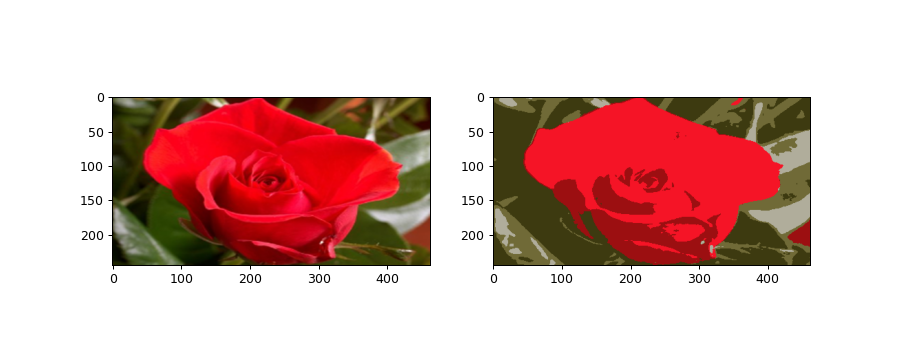

In [3]:
img1 = plt.imread('images/rose.bmp')
app1 = MyKmeansApp(img1, num_clusters=5)
im1 = app1.return_img()

plt.figure(1,figsize = (10, 4))
ax11 = plt.subplot(121)
plt.imshow(img1)
ax12 = plt.subplot(122)
plt.imshow(im1)
plt.show()

<IPython.core.display.Javascript object>


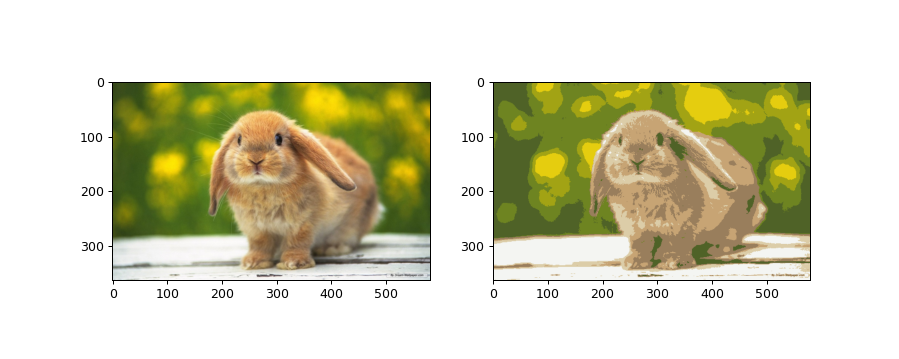

In [4]:
img2 = plt.imread('images/bunny.bmp')
app2 = MyKmeansApp(img2, num_clusters=8)
im2 = app2.return_img()

plt.figure(2,figsize = (10, 4))
ax21 = plt.subplot(121)
plt.imshow(img2)
ax22 = plt.subplot(122)
plt.imshow(im2)
plt.show()

<IPython.core.display.Javascript object>


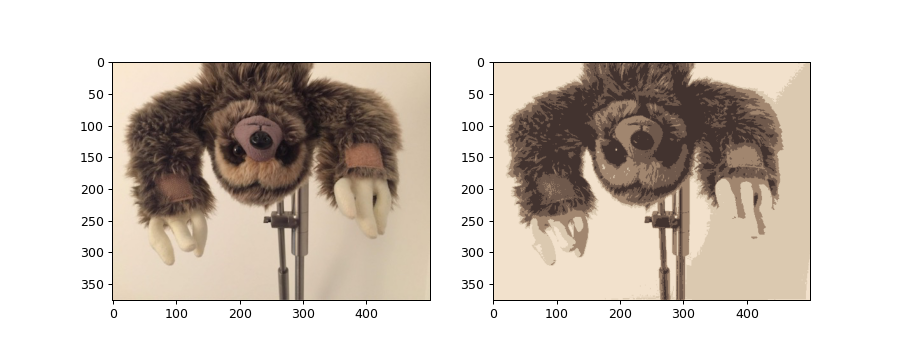

In [11]:
img3 = plt.imread('images/sloth.JPG')
app3 = MyKmeansApp(img3, num_clusters=5)
im3 = app3.return_img()

plt.figure(3,figsize = (10, 4))
ax31 = plt.subplot(121)
plt.imshow(img3)
ax32 = plt.subplot(122)
plt.imshow(im3)
plt.show()

<IPython.core.display.Javascript object>


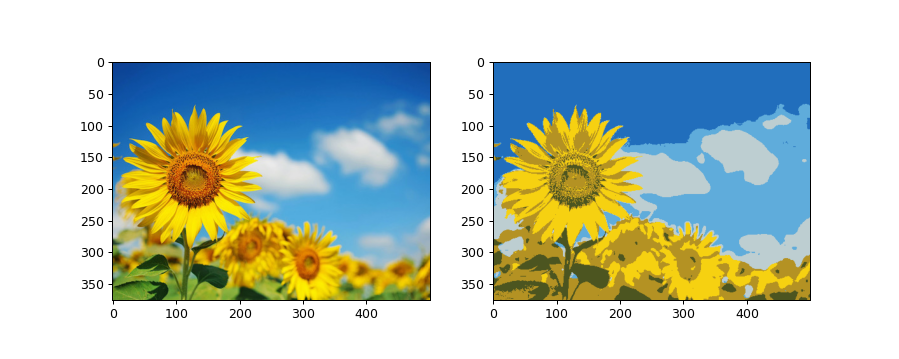

In [5]:
img4 = plt.imread('images/sunflower.jpg')
app4 = MyKmeansApp(img4, num_clusters=6)
im4 = app4.return_img()

plt.figure(4,figsize = (10, 4))
ax41 = plt.subplot(121)
plt.imshow(img4)
ax42 = plt.subplot(122)
plt.imshow(im4)
plt.show()

<IPython.core.display.Javascript object>


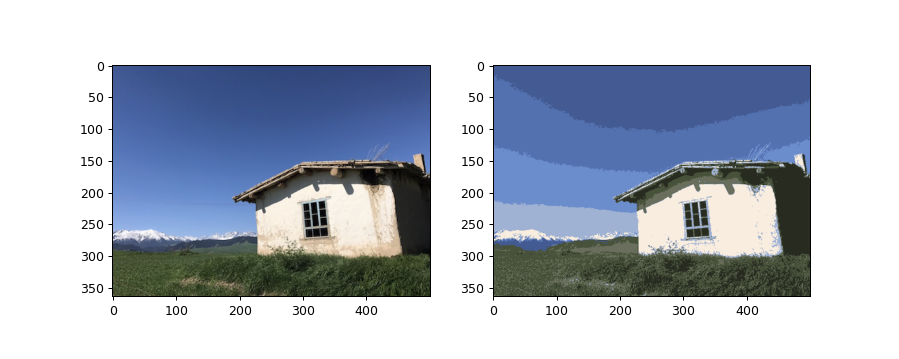

In [7]:
img5 = plt.imread('images/house.jpg')
app5 = MyKmeansApp(img5, num_clusters=8)
im5 = app5.return_img()

plt.figure(5,figsize = (10, 4))
ax51 = plt.subplot(121)
plt.imshow(img5)
ax52 = plt.subplot(122)
plt.imshow(im5)
plt.show()

<IPython.core.display.Javascript object>


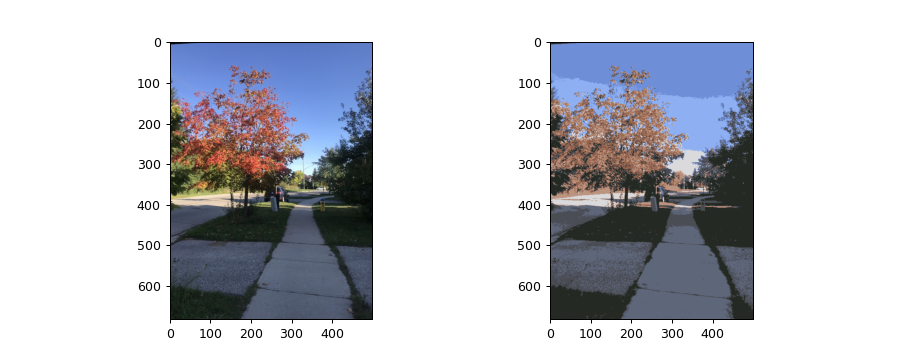

In [8]:
img6 = plt.imread('images/waterloo.jpg')
app6 = MyKmeansApp(img6, num_clusters=8)
im6 = app6.return_img()

plt.figure(6,figsize = (10, 4))
ax61 = plt.subplot(121)
plt.imshow(img6)
ax62 = plt.subplot(122)
plt.imshow(im6)
plt.show()

<IPython.core.display.Javascript object>


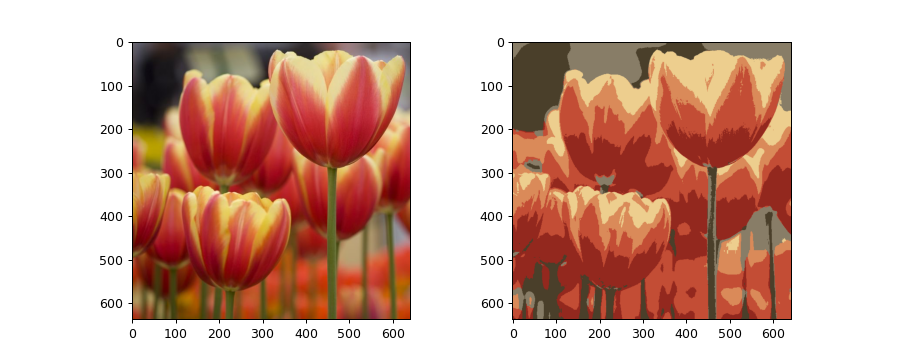

In [10]:
img7 = plt.imread('images/tulip.jpg')
app7 = MyKmeansApp(img7, num_clusters=6)
im7 = app7.return_img()

plt.figure(7,figsize = (10, 4))
ax71 = plt.subplot(121)
plt.imshow(img7)
ax72 = plt.subplot(122)
plt.imshow(im7)
plt.show()